In [2]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

import os
import json

pylab.rcParams['figure.figsize'] = 12, 8
pylab.rcParams['figure.dpi'] = 100

Populating the interactive namespace from numpy and matplotlib


In [2]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [9]:
puidata = os.getenv('PUIDATA')
!ls $puidata

201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201705-citibike-tripdata.csv.zip
201803_citibike_tripdata.csv.zip
311_Service_Requests_from_2010_to_Present_head.csv
311_Service_Requests_from_2010_to_Present_short.csv
ACS_16_1YR_GCT2801
dhsdaily.csv
DOB_Complaints_311.csv
JC-201705-citibike-tripdata.csv
JC-201803-citibike-tripdata.csv
linkNYClocations.csv
NYPD_7_Major_Felony_Incidents.csv
PLUTO_for_WEB
PUMA_NYC_shapefile
times.txt


# IDEA:
## Women are less likely than men to choose biking _for commuting_

# NULL HYPOTHESIS:
## The proportion of men biking on weekends is _the same_ or _higher_  than the proportion of women biking on weekends

# _$H_0$_ : $\frac{W_{\mathrm{weekend}}}{W_{\mathrm{total}}} <= \frac{M_{\mathrm{weekend}}}{M_{\mathrm{total}}}$
# _$H_1$_ : $\frac{W_{\mathrm{weekend}}}{W_{\mathrm{total}}} > \frac{M_{\mathrm{total}}}{M_{\mathrm{total}}}$

or identically:

# _$H_0$_ : $\frac{W_{\mathrm{weekend}}}{W_{\mathrm{total}}} - \frac{M_{\mathrm{weekend}}}{M_{\mathrm{total}}} <= 0 $
# _$H_1$_ : $\frac{W_{\mathrm{weekend}}}{W_{\mathrm{total}}} - \frac{M_{\mathrm{weekend}}}{M_{\mathrm{total}}} > 0$
## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

In [5]:
df = pd.read_csv(puidata + '/201501-citibike-tripdata.csv')
df['date'] = pd.to_datetime(df['starttime'])
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00


In [6]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date'],
      dtype='object')

In [10]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)

In [11]:
df.head()

,gender,date
0,2,2015-01-01 00:01:00
1,1,2015-01-01 00:02:00
2,1,2015-01-01 00:04:00
3,1,2015-01-01 00:04:00
4,1,2015-01-01 00:05:00


We want to get the number of women

In [64]:
#women
w_count= df['date'][df['gender'] == 2].groupby(df['date'].dt.weekday).count()

# men
m_count= df['date'][df['gender'] == 1].groupby(df['date'].dt.weekday).count()

In [101]:
w_count

date
0     6714
1     6649
2     7509
3     9337
4    10186
5     5908
6     5790
Name: date, dtype: int64

In [99]:
w_count.sum()

52093

[Text(0,0,'Mon'),
 Text(0,0,'Tue'),
 Text(0,0,'Wed'),
 Text(0,0,'Thu'),
 Text(0,0,'Fri'),
 Text(0,0,'Sat'),
 Text(0,0,'Sun')]

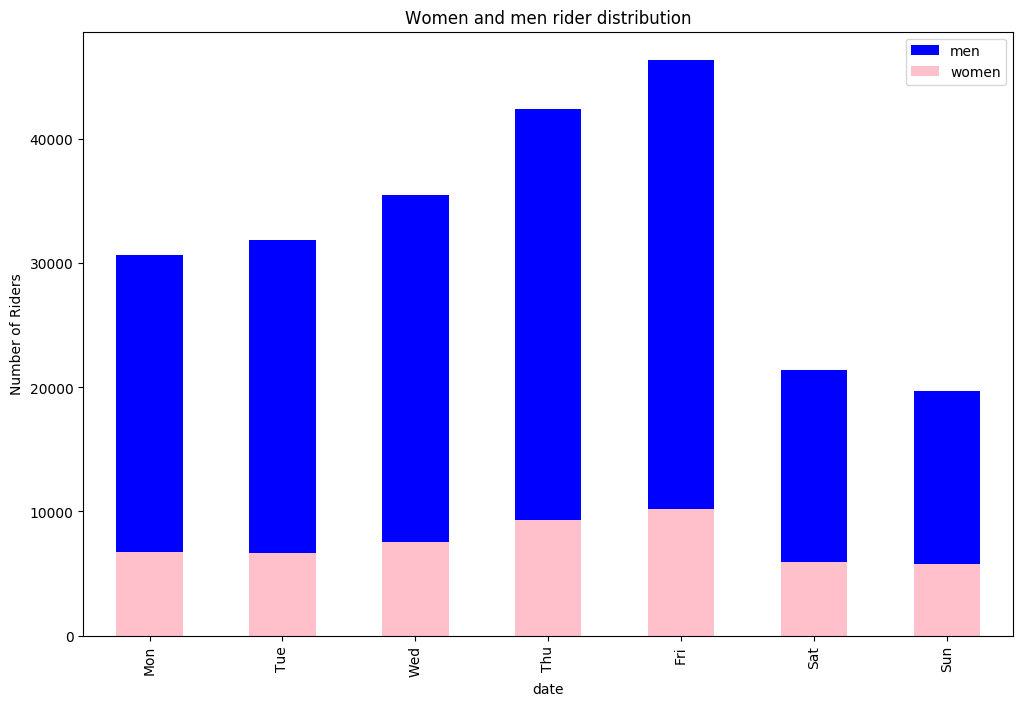

In [65]:
fig, ax = pl.subplots()
m_count.plot(kind='bar', ax=ax, color='blue', label='men')

w_count.plot(kind='bar', ax=ax, color='pink', label='women')

pl.title('Women and men rider distribution')
pl.ylabel('Number of Riders')
pl.legend()
ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

[Text(0,0,'Mon'),
 Text(0,0,'Tue'),
 Text(0,0,'Wed'),
 Text(0,0,'Thu'),
 Text(0,0,'Fri'),
 Text(0,0,'Sat'),
 Text(0,0,'Sun')]

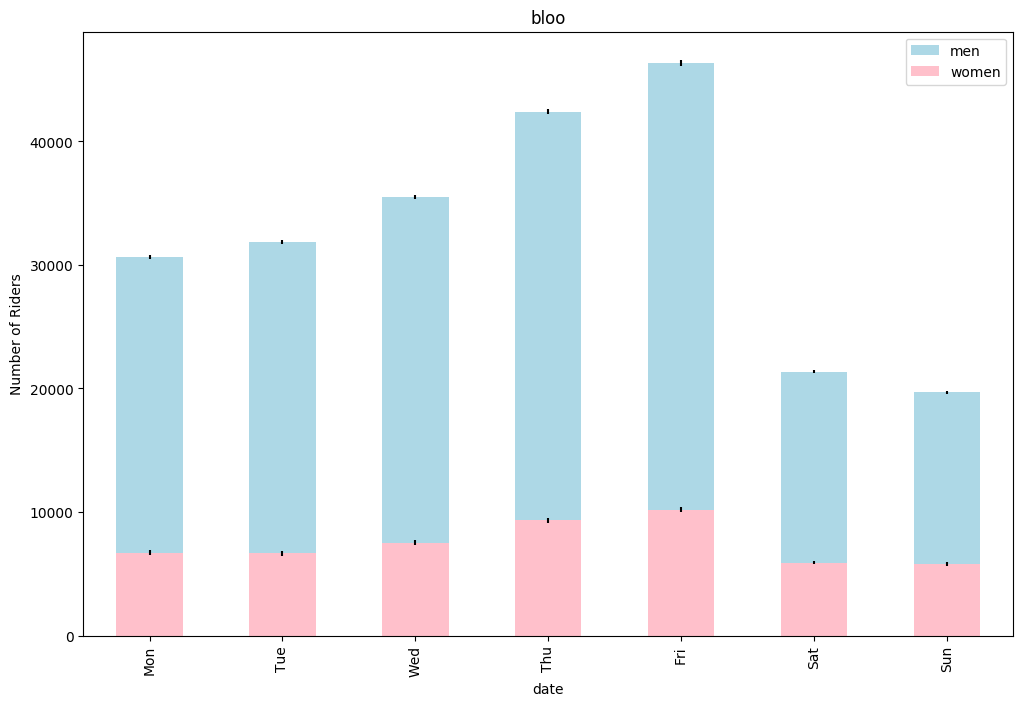

In [97]:
w_error = np.sqrt(w_count)
m_error = np.sqrt(m_count)

fig2, ax2 = pl.subplots()
m_count.plot.bar(yerr=(m_error), color='lightblue', ax=ax2, label='men')
w_count.plot.bar(yerr=(w_error), color='pink', ax=ax2, label='women')

pl.legend()
pl.ylabel('Number of Riders')
pl.title('bloo')
ax2.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

Distribution od citibike riders by gender in January 2015, absolute counts with statistical errors

# Normalize >> proportions

[Text(0,0,'Mon'),
 Text(0,0,'Tue'),
 Text(0,0,'Wed'),
 Text(0,0,'Thu'),
 Text(0,0,'Fri'),
 Text(0,0,'Sat'),
 Text(0,0,'Sun')]

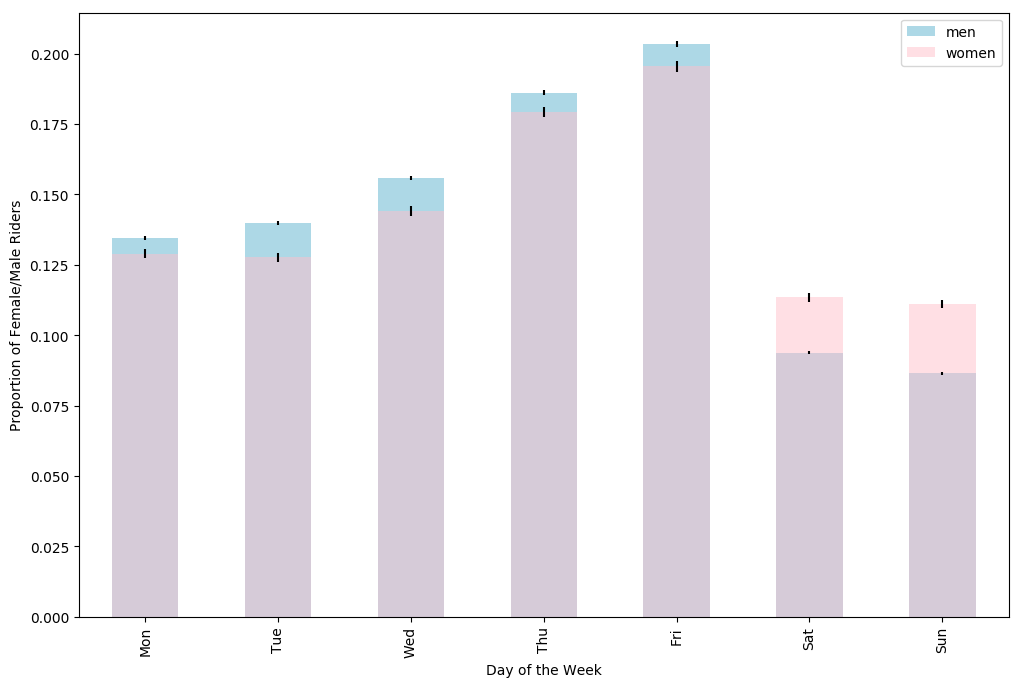

In [112]:
fig3, ax3 = pl.subplots()

# men
m_count= df['date'][df['gender'] == 1].groupby(df['date'].dt.weekday).count()

m_error = np.sqrt(m_count)
m_norm = m_count.sum()
(m_count / m_norm).plot.bar(yerr=[m_error/m_norm], color='lightblue', label='men', ax=ax3)


#women
w_count= df['date'][df['gender'] == 2].groupby(df['date'].dt.weekday).count()

w_norm = w_count.sum()
w_error = np.sqrt(w_count)
(w_count / w_norm).plot.bar(yerr=(w_error / w_norm), color='pink', label='women', ax=ax3, alpha=0.5)


pl.xlabel('Day of the Week')
pl.ylabel('Proportion of Female/Male Riders')
pl.legend()
ax3.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

In [10]:
df = pd.read_csv(puidata + '/JC-201803-citibike-tripdata.csv')

In [11]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,329,2018-03-01 06:37:37.0380,2018-03-01 06:43:06.5520,3183,Exchange Place,40.716247,-74.033459,3202,Newport PATH,40.727224,-74.033759,29284,Subscriber,1981,1
1,118,2018-03-01 07:37:30.1210,2018-03-01 07:39:28.3910,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,29465,Subscriber,1966,1
2,76,2018-03-01 08:26:17.9390,2018-03-01 08:27:34.6770,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,29681,Subscriber,1975,1
3,578,2018-03-01 12:10:36.2160,2018-03-01 12:20:14.8690,3183,Exchange Place,40.716247,-74.033459,3185,City Hall,40.717733,-74.043845,31695,Subscriber,1970,1
4,485,2018-03-01 12:21:47.8800,2018-03-01 12:29:53.2990,3183,Exchange Place,40.716247,-74.033459,3187,Warren St,40.721124,-74.038051,31802,Subscriber,1979,1


In [15]:
df_dob = df[['birth year']]
df_dob.head()

,birth year
0,1981
1,1966
2,1975
3,1970
4,1979


In [13]:
df_dob['birth year'].groupby(df['birth year']).count().head()

birth year
1888     3
1931    19
1941     5
1949    37
1950    61
Name: birth year, dtype: int64

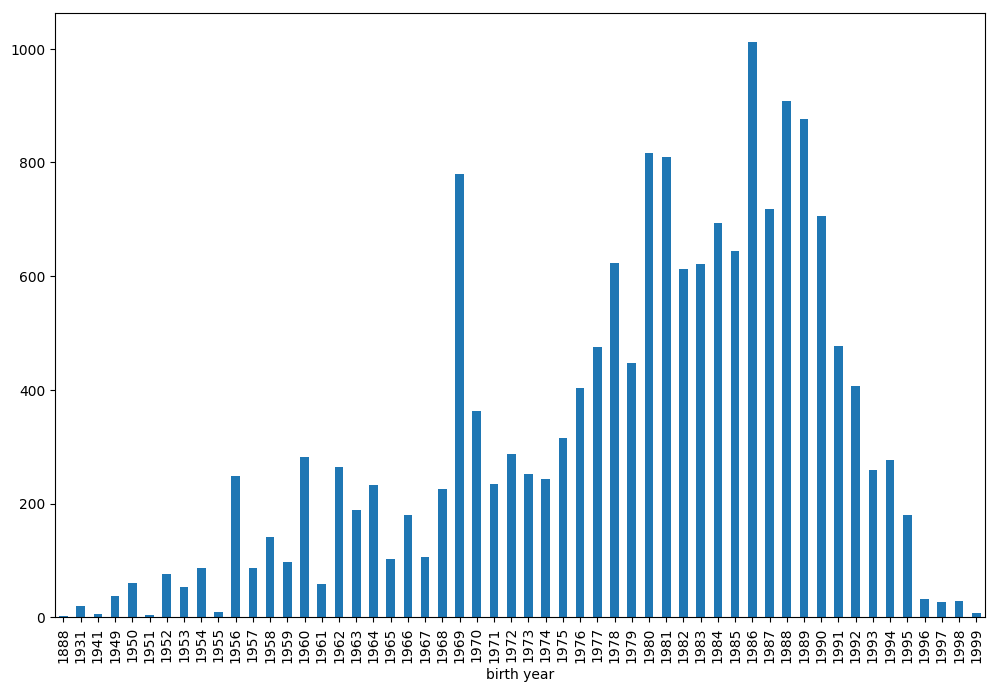

In [14]:
fig4, ax4 = pl.subplots()
df_dob['birth year'].groupby(df['birth year']).count().plot.bar()

In [16]:
G1 = df_dob[(df_dob['birth year'] >= 1965) & (df_dob['birth year'] <= 1980)]

In [43]:
G1.head()

,birth year
1,1966
2,1975
3,1970
4,1979
5,1974


In [44]:
G1.tail()

,birth year
17088,1972
17092,1971
17097,1979
17098,1974
17106,1971


In [50]:
G1 = df_dob[(df_dob['birth year'] >= 1981) & (df_dob['birth year'] <= 1996)]
G1.head()

,birth year
0,1981
6,1984
8,1986
10,1983
11,1987


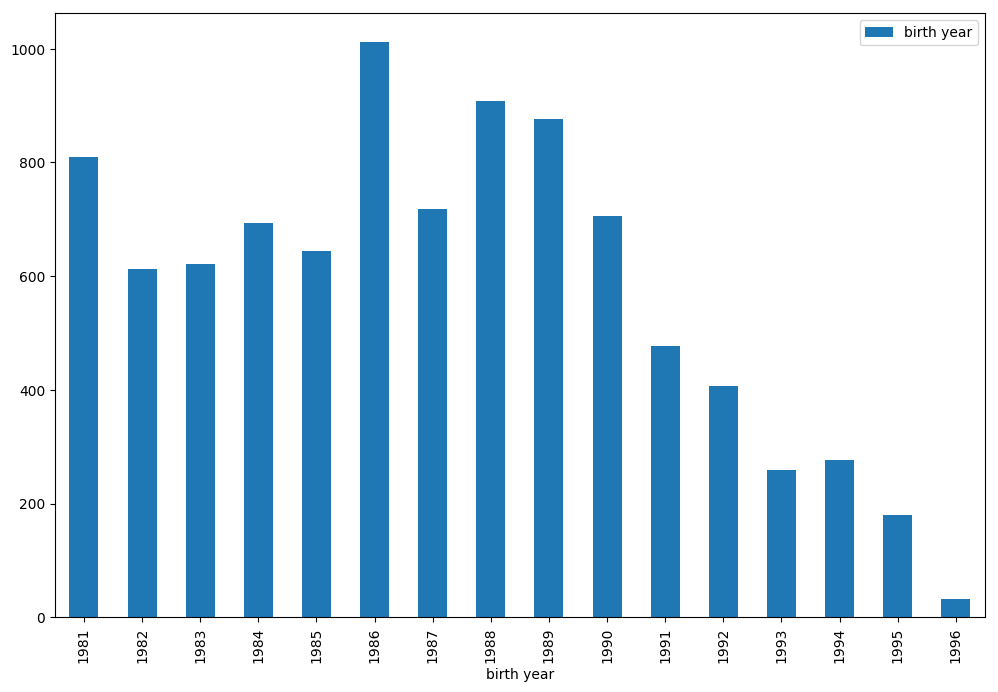

In [51]:
fig5, ax5 = pl.subplots()
G1_count = G1.groupby(df_dob['birth year']).count()
G1_count.plot.bar(ax=ax5)



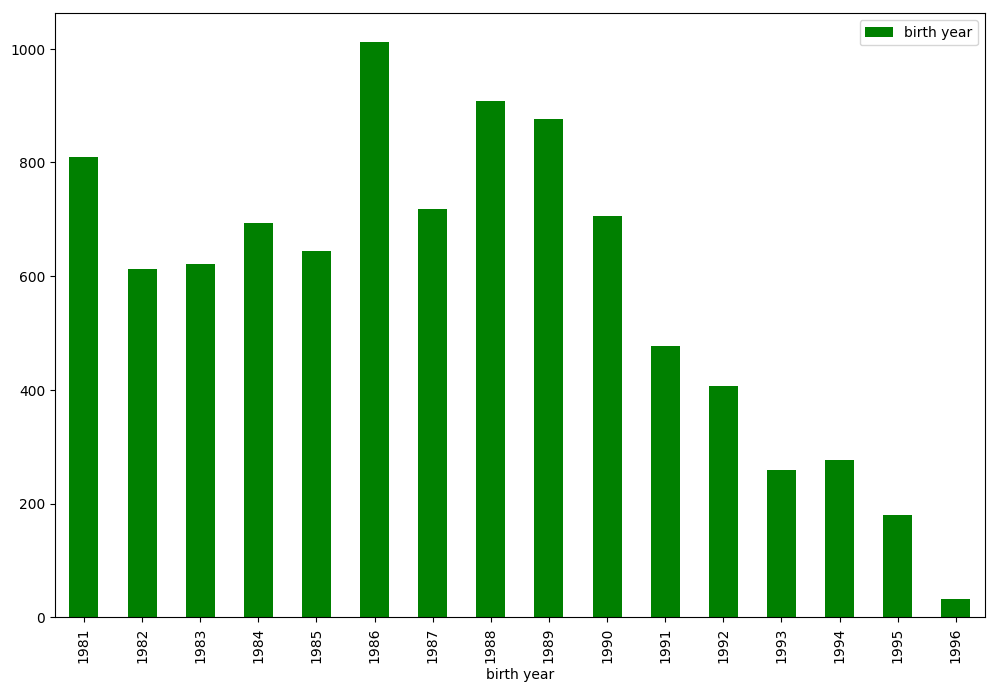

In [56]:
fig5, ax5 = pl.subplots()
G2_count = G2.groupby(df_dob['birth year']).count()
G2_count.plot.bar(color='green', ax=ax5)